In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib import colormaps as cm
import os
import glob
import gaitFunctions
from gaitFunctions import swingTimingProportions
from gaitFunctions import offsetGaitstyleLabels
from scipy import stats
import seaborn as sns

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#a665c9'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.4
marker_color = 'k'

In [3]:
# leg relationships and colors
first_pair = ['L1','R1']
second_pair = ['L2','R2']
third_pair = ['L3','R3']
fourth_pair = ['L4','R4']
rear_legs = fourth_pair
lateral_legs = third_pair + second_pair + first_pair
ipsi_offset_legs = third_pair + second_pair
left_laterals = [x[0] for x in [third_pair, second_pair, first_pair]]
right_laterals = [x[1] for x in [third_pair, second_pair, first_pair]]
all_legs = rear_legs + lateral_legs
left_legs = [x[0] for x in [fourth_pair, third_pair, second_pair, first_pair]]
right_legs = [x[1] for x in [fourth_pair, third_pair, second_pair, first_pair]]
single_leg = ['R4']

# dictionaries of inter-leg relationships
ipsi_legs = {'L4':'L3','R4':'R3','L3':'L2','L2':'L1','R3':'R2','R2':'R1'}
contra_legs = {'L4':'R4','R4':'L4','L3':'R3','L2':'R2','R3':'L3','R2':'L2','L1':'R1','R1':'L1'}

# colors
all_leg_color = 'dimgrey'
L2_L1_color =   second_pair_color
L3_L2_color =   third_pair_color
R2_R1_color =   second_pair_color_alt
R3_R2_color =   third_pair_color_alt

In [4]:
# load data
excel_file = 'all_exemplaris_2024-07-29.xlsx'

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
step_df.head(3)

,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,anterior_offsets,contralateral_offsets,metachronal_lag,mcl_LR_ratio,L3_bearing_change,clip,treatment,individual,date,uniq_id
0,L1,0.575,1.030,0.455,0.182,0.637,0.7143,1.1210,L1:0.8571,R1:0.4286,...,NaN,0.394,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
1,L1,1.212,1.848,0.636,0.182,0.818,0.7775,1.9390,L1:0.8888,R1:0.3888,...,NaN,0.394,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
2,L1,2.030,2.666,0.636,0.273,0.909,0.6997,2.8025,L1:0.8498,R1:0.3333,...,NaN,0.364,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris


# Partitioning Speed

In [5]:
# functions for partitioning speed
def getValuesWithinBoundary(vec,boundary):
    above_min = vec[np.where(vec>=boundary[0])]
    return above_min[np.where(above_min<=boundary[1])]

def getGaitProportionsInSpeedPartition(speed_partition, category_lists):
    
    # get total number of observations in this partition
    all_speeds = []
    for speed_vals in category_lists:
        all_speeds.extend(getValuesWithinBoundary(speed_vals, speed_partition))
    total_observations = len(all_speeds)

    # for each list of speed values, get the percentage of total that are within this partition
    percents_within_partition = []
    for speed_vals in category_lists:
        speed_vals = np.array(speed_vals)
        within_boundary = getValuesWithinBoundary(speed_vals, speed_partition)
        percents_within_partition.append(len(within_boundary) * 100 / total_observations)
        
    return percents_within_partition

def speedPartitionPlot(ax, speed_boundaries, category_lists, category_names, color_dict):
    
    for i in np.arange(len(speed_boundaries)-1):
        this_partition = [speed_boundaries[i],speed_boundaries[i+1]]

        percent_within_partition = getGaitProportionsInSpeedPartition(this_partition, category_lists)

        bottom = 0
        for j,catname in enumerate(category_names):
            ax.bar(i,percent_within_partition[j],color=color_dict[catname.replace(' ','_')],bottom=bottom)
            bottom += percent_within_partition[j]

    ax.set_ylabel('Percent')
    ax.set_xticks([0,1,2],['Low','Medium','High'])
    ax.set_xlabel(speed_col)
    
    return ax

def gaitDensityPlot(ax, categories, gaitspeed_df, speed_col, include_unclassified):
    # which leg sets to look at?
    if 'pentapod' in categories:
        gait_col = 'gaits_lateral'
        legset = 'hexapod'
    else:
        gait_col = 'gaits_rear'
        legset = 'bipod'

    # set up plot colors
    combos, color_dict = gaitFunctions.get_gait_combo_colors(legset)
    
    category_names = [x.replace('_',' ') for x in categories]
    category_lists = []

    # get speed data for each category
    for i, category in enumerate(categories):
        category_lists.append(gaitspeed_df[gaitspeed_df[gait_col]==category][speed_col].values)
    if include_unclassified:
        category_lists.append(gaitspeed_df[~gaitspeed_df[gait_col].isin(categories)][speed_col].values)
        category_names.append('unclassified')
    # print(category_names)

    for i, catname in enumerate(category_names):
        ax = sns.histplot(category_lists[i], stat='probability', binwidth=0.005, ax=ax, kde=True,
                          element='step', fill=False, visible=False, color=color_dict[catname.replace(' ','_')],
                         legend=True, label=catname)
        
    return ax, category_lists, category_names, color_dict

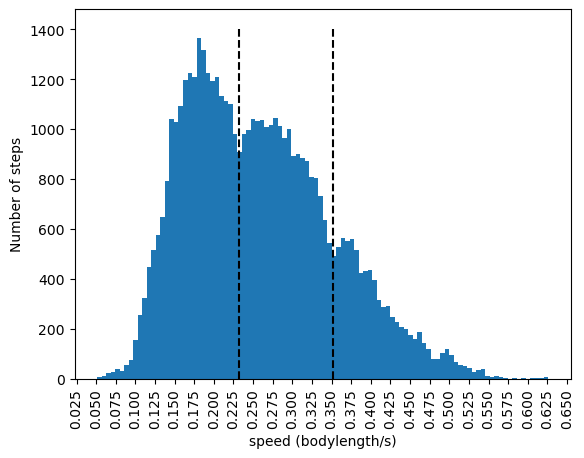

In [6]:
'''
How to partition the speed categories into slow, medium, fast?
First, see if there are any boundaries evident in the speed data
'''
gaitspeed_df = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
speed_col = 'speed (bodylength/s)' # 'speed (bodylength/s)' or 'speed (mm/s)' 

# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.232,0.352,1]

import matplotlib.ticker as ticker
tick_spacing = 0.025
fig, ax = plt.subplots(1,1)
ax.hist(gaitspeed_df[speed_col].values, bins=100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of steps')
ax.set_xlabel(speed_col)
for x in [1,2]:
    ax.plot([speed_boundaries[x],speed_boundaries[x]],[0,1410],'--k')
plt.show()

## look at between-individual distribution of speeds ... similar discontinuities?

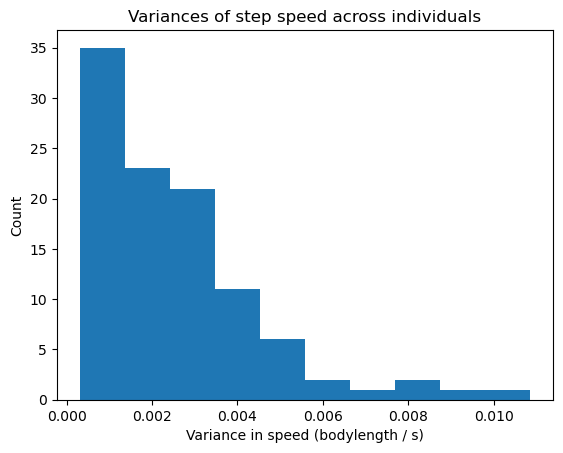

104.00779084868515 0.0


In [7]:
individuals = np.sort(np.unique(gaitspeed_df.uniq_id.values))
individual_speeds = []

for i, individual in enumerate(individuals):
    ind_df = gaitspeed_df[gaitspeed_df['uniq_id'] == individual]
    individual_speeds.append(ind_df[speed_col].values)
individual_speeds = [np.array(x) for x in individual_speeds]
individual_speed_variances = [np.var(x) for x in individual_speeds]

plt.hist(individual_speed_variances)
plt.title('Variances of step speed across individuals')
plt.ylabel('Count')
plt.xlabel('Variance in speed (bodylength / s)')
plt.show()

levene, p = stats.levene(*individual_speeds)
print(levene, p)

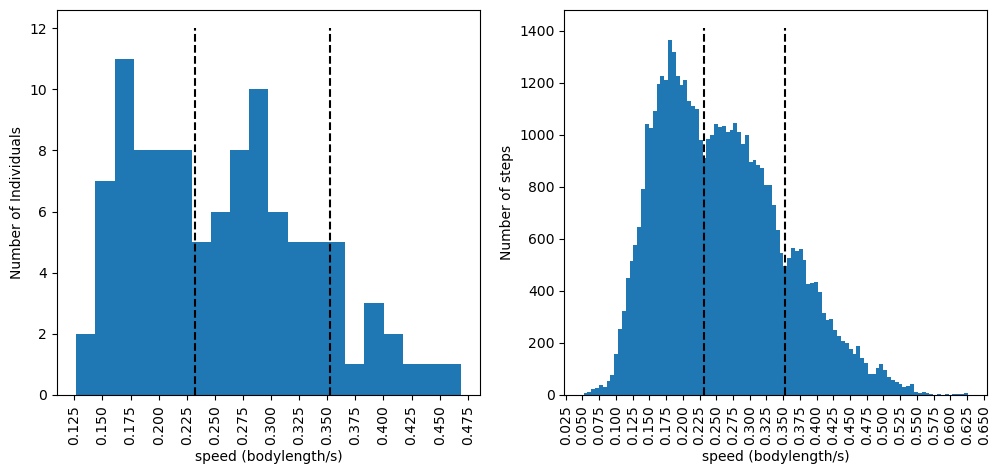

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
speed_boundaries = [0,0.232,0.352,1]
tick_spacing = 0.025

individual_speed_means = [np.mean(x) for x in individual_speeds]
ax1.hist(individual_speed_means, bins=20)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Number of Individuals')
ax1.set_xlabel(speed_col)

ax2.hist(gaitspeed_df[speed_col].values, bins=100)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('Number of steps')
ax2.set_xlabel(speed_col)


for x in [1,2]:
    ax1.plot([speed_boundaries[x],speed_boundaries[x]],[0,12],'--k')
    ax2.plot([speed_boundaries[x],speed_boundaries[x]],[0,1410],'--k')

plt.show()

# Speed partitions and Phase Offsets

5175 5175


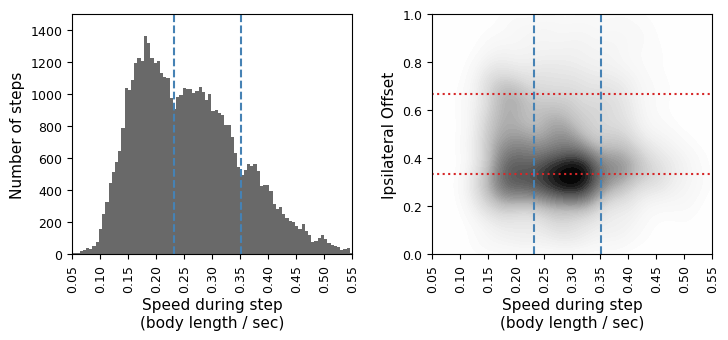

In [9]:
f = plt.figure(figsize=(8,3))
ax1 = f.add_axes([0.1,0.1,0.35,0.8])
ax2 = f.add_axes([0.55,0.1,0.35,0.8], sharex=ax1)

import matplotlib.ticker as ticker
tick_spacing = 0.05

### SPEED HISTOGRAM
gaitspeed_df = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
speed_col = 'speed (bodylength/s)' # 'speed (bodylength/s)' or 'speed (mm/s)' 

ax1.hist(gaitspeed_df[speed_col].values, bins=100, color='dimgrey')
ax1.set_ylabel('Number of steps')

### Speed vs. Ispsilateral offsets
ipsi_proportions = []
ipsi_speeds = []
ipsi_offsets = []

for leg in ipsi_offset_legs:
    ipsi_offsets, ipsi_proportions, ipsi_speeds = swingTimingProportions(ipsi_offsets, ipsi_proportions, 
                                                                         ipsi_speeds, step_df, leg, 
                                                                         ipsi_legs[leg])

print(len(ipsi_proportions), len(ipsi_speeds))

ax2 = sns.kdeplot(ax=ax2, x=ipsi_speeds, y=ipsi_proportions, fill=True, cmap='Greys', thresh=0, levels=50)
ax2.set_ylabel('Ipsilateral Offset', fontsize=14)
ax2.plot([0,1],[1/3,1/3],':',color=ipsi_color)
ax2.plot([0,1],[2/3,2/3],':',color=ipsi_color)
ax2.set_ylim([0,1])

for ax in [ax1,ax2]:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.tick_params(axis='x', rotation=90)
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.set_xlabel('Speed during step\n(body length / sec)', fontsize=axis_fontsize)
    # ax.xaxis.label.set_text('hihihihi') # cool

# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.232,0.352,1]

maxy = 1500

for i in [1,2]:
    ax1.plot([speed_boundaries[i],speed_boundaries[i]],[0,maxy],'--',color='steelblue')
    ax2.plot([speed_boundaries[i],speed_boundaries[i]],[0,1],'--',color='steelblue')

ax1.set_ylim([0,maxy])
ax1.set_xlim([0.05,0.55])
    
plt.show()

## contralateral phase offsets in speed partitions

4978 4978


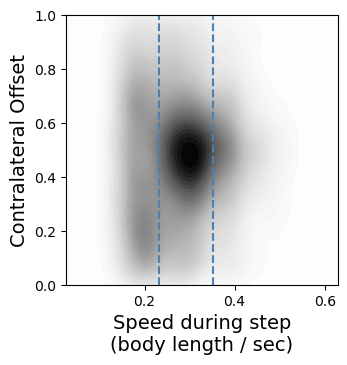

In [10]:
contra_proportions = []
contra_speeds = []
contra_offsets = []

for leg in ipsi_offset_legs:
    contra_offsets, contra_proportions, contra_speeds = swingTimingProportions(contra_offsets, contra_proportions, 
                                                                               contra_speeds, step_df, leg, 
                                                                               contra_legs[leg])

print(len(contra_proportions), len(contra_speeds))

fig,ax2 = plt.subplots(1,1,figsize=(3.5,3.5))
ax2 = sns.kdeplot(ax=ax2, x=contra_speeds, y=contra_proportions, fill=True, cmap='Greys', thresh=0, levels=50)

ax2.set_xlabel('Speed during step\n(body length / sec)', fontsize=14)
ax2.set_ylabel('Contralateral Offset', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_ylim([0,1])

for i in [1,2]:
    ax2.plot([speed_boundaries[i],speed_boundaries[i]],[0,1],'--',color='steelblue')

# ax2.set_aspect('equal')
plt.show()

# Partitioned speeds: phase offset violin plots

In [11]:
# get speeds for steps

ipsi_swing_offset_proportions = []
contra_swing_offset_proportions = []
speeds=[]

# code modified from swingTimingProportions in gaitFunctions
individuals = np.sort(np.unique(step_df['uniq_id'].values))
for ref_leg in ipsi_offset_legs:
    for individual in individuals:
        individual_data = step_df[step_df['uniq_id']==individual]
        ref_leg_swings = individual_data[individual_data['legID'] == ref_leg]['UpTime'].values
        anterior_leg_swings = individual_data[individual_data['legID'] == ipsi_legs[ref_leg]]['UpTime'].values
        opposite_leg_swings = individual_data[individual_data['legID'] == contra_legs[ref_leg]]['UpTime'].values
        
        ref_leg_speeds = individual_data[individual_data['legID'] == ref_leg]['speed_during_step'].values
        ref_leg_bodylengths = individual_data[individual_data['legID'] == ref_leg]['average_tardigrade_length'].values
        
        for i, ref_swing in enumerate(ref_leg_swings[:-1]):
            next_ref_swing = ref_leg_swings[i+1]
            next_ant_idx = np.where(anterior_leg_swings>ref_swing)[0]
            next_opp_idx = np.where(opposite_leg_swings>ref_swing)[0]
            
            # add speed
            speed_during_step = ref_leg_speeds[i]
            length_during_step = ref_leg_bodylengths[i]
            
            if len(next_ant_idx) > 0 and len(next_opp_idx) > 0:
                next_ant_swing = anterior_leg_swings[next_ant_idx[0]]
                next_opp_swing = opposite_leg_swings[next_opp_idx[0]]
                
                ref_cycle = next_ref_swing-ref_swing
                
                ant_swing_offset = next_ant_swing-ref_swing
                opp_swing_offset = next_opp_swing-ref_swing
                
                ant_swing_phase_proportion = ant_swing_offset / ref_cycle
                opp_swing_phase_proportion = opp_swing_offset / ref_cycle
                
                if ant_swing_phase_proportion <= ref_cycle and opp_swing_phase_proportion < ref_cycle:
                    ipsi_swing_offset_proportions.append(ant_swing_phase_proportion) 
                    contra_swing_offset_proportions.append(opp_swing_phase_proportion)
                    speeds.append(speed_during_step/length_during_step)

In [12]:
speed_boundaries = [0,0.232,0.352,1]

fast_contra = []
fast_ipsi = []
medium_contra = []
medium_ipsi = []
slow_contra = []
slow_ipsi = []

for i, speed in enumerate(speeds):
    if speed_boundaries[0] < speed <= speed_boundaries[1]:
        slow_contra.append(contra_swing_offset_proportions[i])
        slow_ipsi.append(ipsi_swing_offset_proportions[i])
    elif speed_boundaries[1] < speed <= speed_boundaries[2]:
        medium_contra.append(contra_swing_offset_proportions[i])
        medium_ipsi.append(ipsi_swing_offset_proportions[i])
    else:
        fast_contra.append(contra_swing_offset_proportions[i])
        fast_ipsi.append(ipsi_swing_offset_proportions[i])

[1550, 1992, 839, 1518, 1995, 839]


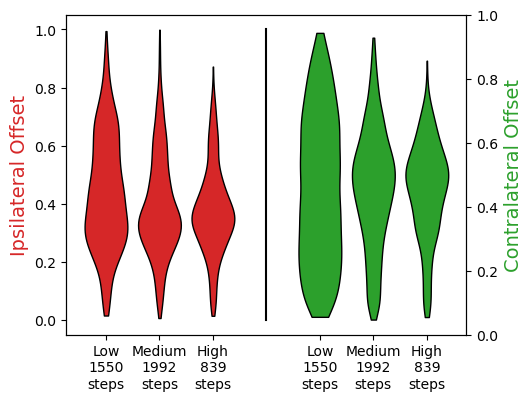

In [13]:
# Partitioned speed and ipsi and contra offsets
f = plt.figure(figsize=(5,4))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax2 = ax.twinx()

violin_positions = np.array([1,2,3,5,6,7])
violin_data = [slow_ipsi, medium_ipsi, fast_ipsi, slow_contra, medium_contra, fast_contra]
violin_data = [np.array(x) for x in violin_data]
violin_data = [x[np.where(x>0)] for x in violin_data]
violin_data = [x[np.where(x<1)] for x in violin_data]

violin_nums = [len(x) for x in violin_data]
print(violin_nums)

violin_xlabs = np.array(['Low\n'+str(violin_nums[0])+'\nsteps',
                  'Medium\n'+str(violin_nums[1])+'\nsteps',
                  'High\n'+str(violin_nums[2])+'\nsteps'] * 2)

violin_colors = [ipsi_color] * 3 + [contra_color] * 3
violins = ax.violinplot(violin_data, positions=violin_positions, widths=0.8, 
                         showmeans=False, showextrema=False, showmedians=False)

for i, pc in enumerate(violins['bodies']):
    pc.set_facecolor(violin_colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    
# ax.plot([0,4],[1/3,1/3],':',c=tetra_color)
# ax.plot([0,4],[1/2,1/2],':',c=tripod_color)
# ax.plot([0,4],[2/3,2/3],':',c=tetra_color)
ax.plot([4,4],[0,1],'-k')

ax.set_ylabel('Ipsilateral Offset',color=ipsi_color,fontsize=14)
ax2.set_ylabel('Contralateral Offset',color=contra_color,fontsize=14)
ax.set_xticks(violin_positions,violin_xlabs)
ax.tick_params(axis='both', which='major', labelsize=10)

# ax.set_ylim([0,1])
plt.show()

# Speed partitions and idealized ICPs at phase offset intersections

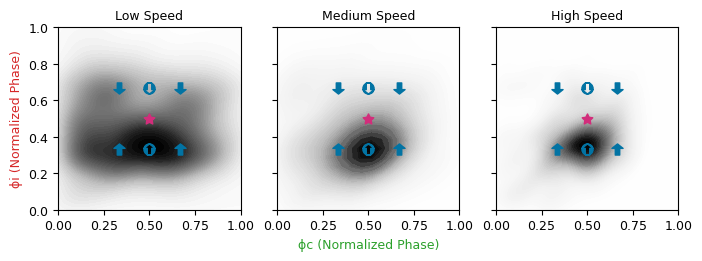

In [14]:
f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(8,3),sharey=True)

cmap = 'Greys' # Greys or binary

ax1 = sns.kdeplot(ax=ax1, x=slow_contra, y=slow_ipsi, fill=True, cmap=cmap, thresh=0, levels=50) 
ax1.set_title('Low Speed', fontsize=tick_fontsize)

ax2 = sns.kdeplot(ax=ax2, x=medium_contra, y=medium_ipsi, fill=True, cmap=cmap, thresh=0, levels=50) 
ax2.set_title('Medium Speed', fontsize=tick_fontsize)

ax3 = sns.kdeplot(ax=ax3, x=fast_contra, y=fast_ipsi, fill=True, cmap=cmap, thresh=0, levels=50) 
ax3.set_title('High Speed', fontsize=tick_fontsize)

for ax in [ax1,ax2,ax3]:
    ax=offsetGaitstyleLabels(ax, with_text=False, fontsize=4, markersize=8)
#     ax.set_xlim([0.05,0.95])
#     ax.set_ylim([0.05,0.95]) 
#     ax.set_xlabel('ϕc (Normalized Phase)', fontsize=tick_fontsize, color=contra_color)
    ax.xaxis.label.set_text('') # cool
    ax.set_ylabel('ϕi (Normalized Phase)', fontsize=tick_fontsize, color=ipsi_color)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

ax2.set_xlabel('ϕc (Normalized Phase)', fontsize=tick_fontsize, color=contra_color)
plt.show()

# Speed partitions and ICP composition

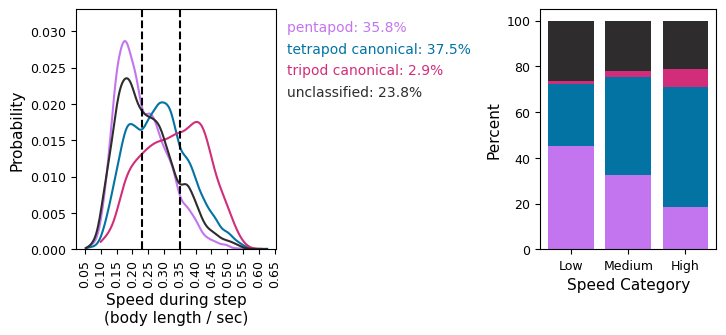

In [15]:
'''
Categories to match Nirody et al. 2021
'''
# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.232,0.352,1]

# set up categories and values to plot
categories = ['pentapod','tetrapod_canonical','tripod_canonical']
# include unclassified?
include_unclassified = True

# set up figure
f = plt.figure(figsize=(8,3))
ax1 = f.add_axes([0.1,0.1,0.25,0.8])
axLeg = f.add_axes([0.33,0.1,0.2,0.8])
ax2 = f.add_axes([0.68,0.1,0.22,0.8])

# get LEFT axis
ax1, category_lists, category_names, color_dict = gaitDensityPlot(ax1, categories, gaitspeed_df, speed_col, include_unclassified)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.tick_params(axis='x', rotation=90)
ax1.yaxis.label.set_size(axis_fontsize)
ax1.set_xlabel('Speed during step\n(body length / sec)', fontsize=axis_fontsize)

'''
RIGHT = % in each gait in speed categories low, medium, high
'''
# all_speeds = []
# for speed_vals in category_lists:
#     all_speeds.extend(speed_vals)
# plot distribution of different speeds?
# ax2 = sns.histplot(all_speeds, binwidth = 0.01, ax=ax2)

ax2 = speedPartitionPlot(ax2, speed_boundaries, category_lists, category_names, color_dict)
ax2.xaxis.label.set_text('Speed Category')
ax2.yaxis.label.set_size(axis_fontsize)
ax2.xaxis.label.set_size(axis_fontsize)

# fake legend
legend_maxy = 5
legend_yincrement = 0.5
legend_x = 2
# how many are in each gait category
percents_in_category = [np.round(len(x) * 100 / np.sum([len(x) for x in category_lists]),1) for x in category_lists]
for i, catname in enumerate(category_names):
    axLeg.text(legend_x, legend_maxy-(i*legend_yincrement), 
            catname + ': ' + str(percents_in_category[i]) + '%', 
            color=color_dict[catname.replace(' ','_')])
axLeg.set_axis_off()
axLeg.set_xlim([1.5,4.5])
axLeg.set_ylim([0,5.5])

max_line = 0.033
for i in [1,2]:
    ax1.plot([speed_boundaries[i],speed_boundaries[i]],[0,max_line],'--k')

ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
ax1.set_ylim([0,max_line])
plt.show()

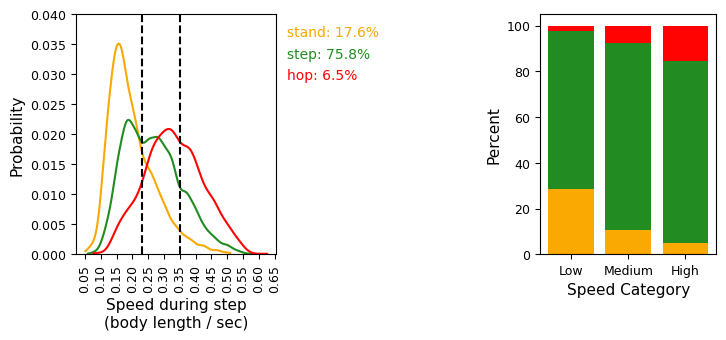

In [16]:
'''
rear leg ICPs
'''
# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.232,0.352,1]

# set up categories and values to plot
rear_categories = ['stand','step','hop']
# include unclassified?
rear_include_unclassified = False

# set up figure
f = plt.figure(figsize=(8,3))
ax1 = f.add_axes([0.1,0.1,0.25,0.8])
axLeg = f.add_axes([0.33,0.1,0.2,0.8])
ax2 = f.add_axes([0.68,0.1,0.22,0.8])

# get LEFT axis
ax1, rear_category_lists, rear_category_names, rear_color_dict = gaitDensityPlot(ax1, 
                                                                  rear_categories, 
                                                                  gaitspeed_df, 
                                                                  speed_col, 
                                                                  rear_include_unclassified)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.tick_params(axis='x', rotation=90)
ax1.yaxis.label.set_size(axis_fontsize)
ax1.set_xlabel('Speed during step\n(body length / sec)', fontsize=axis_fontsize)

'''
RIGHT = % in each gait in speed categories low, medium, high
'''
# all_speeds = []
# for speed_vals in category_lists:
#     all_speeds.extend(speed_vals)
# plot distribution of different speeds?
# ax2 = sns.histplot(all_speeds, binwidth = 0.01, ax=ax2)

# partition speeds into three groups: low, medium, high
ax2 = speedPartitionPlot(ax2, speed_boundaries, rear_category_lists, 
                         rear_category_names, rear_color_dict)
ax2.xaxis.label.set_text('Speed Category')
ax2.yaxis.label.set_size(axis_fontsize)
ax2.xaxis.label.set_size(axis_fontsize)

# fake legend
legend_maxy = 5
legend_yincrement = 0.5
legend_x = 2
# how many are in each gait category
rear_percents_in_category = [np.round(len(x) * 100 / np.sum([len(x) for x in rear_category_lists]),1) for x in rear_category_lists]
for i, catname in enumerate(rear_category_names):
    axLeg.text(legend_x, legend_maxy-(i*legend_yincrement), 
            catname + ': ' + str(rear_percents_in_category[i]) + '%', 
            color=rear_color_dict[catname.replace(' ','_')])
axLeg.set_axis_off()
axLeg.set_xlim([1.5,4.5])
axLeg.set_ylim([0,5.5])

max_line = 0.04
for i in [1,2]:
    ax1.plot([speed_boundaries[i],speed_boundaries[i]],[0,max_line],'--k')

for ax in [ax1,ax2]:
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.label.set_size(axis_fontsize)
ax1.set_ylim([0,max_line])

plt.show()

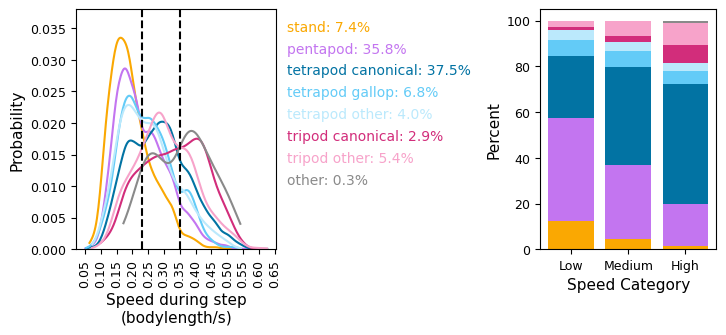

In [17]:
'''
All hexapod ICP categories
'''

# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.232,0.352,1]

# set up categories and values to plot
hex_categories = ['stand','pentapod','tetrapod_canonical','tetrapod_gallop','tetrapod_other',
              'tripod_canonical','tripod_other','other']
# include unclassified?
hex_include_unclassified = False

# set up figure
f = plt.figure(figsize=(8,3))
ax1 = f.add_axes([0.1,0.1,0.25,0.8])
axLeg = f.add_axes([0.33,0.1,0.2,0.8])
ax2 = f.add_axes([0.68,0.1,0.22,0.8])

# get LEFT axis
ax1, hex_category_lists, hex_category_names, hex_color_dict = gaitDensityPlot(ax1, 
                        hex_categories, gaitspeed_df, speed_col, hex_include_unclassified)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.tick_params(axis='x', rotation=90)
ax1.yaxis.label.set_size(axis_fontsize)
ax1.set_xlabel('Speed during step\n(bodylength/s)', fontsize=axis_fontsize)
ax1.set_ylim([0,0.03])

'''
RIGHT = % in each gait in speed categories low, medium, high
'''
# all_speeds = []
# for speed_vals in category_lists:
#     all_speeds.extend(speed_vals)
# plot distribution of different speeds?
# ax2 = sns.histplot(all_speeds, binwidth = 0.01, ax=ax2)

# partition speeds into three groups: low, medium, high
ax2 = speedPartitionPlot(ax2, speed_boundaries, hex_category_lists, 
                         hex_category_names, hex_color_dict)
ax2.xaxis.label.set_text('Speed Category')
ax2.yaxis.label.set_size(axis_fontsize)
ax2.xaxis.label.set_size(axis_fontsize)

# fake legend
legend_maxy = 5
legend_yincrement = 0.5
legend_x = 2
# how many are in each gait category
hex_percents_in_category = [np.round(len(x) * 100 / np.sum([len(x) for x in hex_category_lists]),1) for x in hex_category_lists]
for i, catname in enumerate(hex_category_names):
    axLeg.text(legend_x, legend_maxy-(i*legend_yincrement), 
            catname + ': ' + str(hex_percents_in_category[i]) + '%', 
            color=hex_color_dict[catname.replace(' ','_')])
axLeg.set_axis_off()
axLeg.set_xlim([1.5,4.5])
axLeg.set_ylim([0,5.5])

max_line = 0.038
for i in [1,2]:
    ax1.plot([speed_boundaries[i],speed_boundaries[i]],[0,max_line],'--k')

for ax in [ax1,ax2]:
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.label.set_size(axis_fontsize)
ax1.set_ylim([0,max_line])

plt.show()

# Figure 5

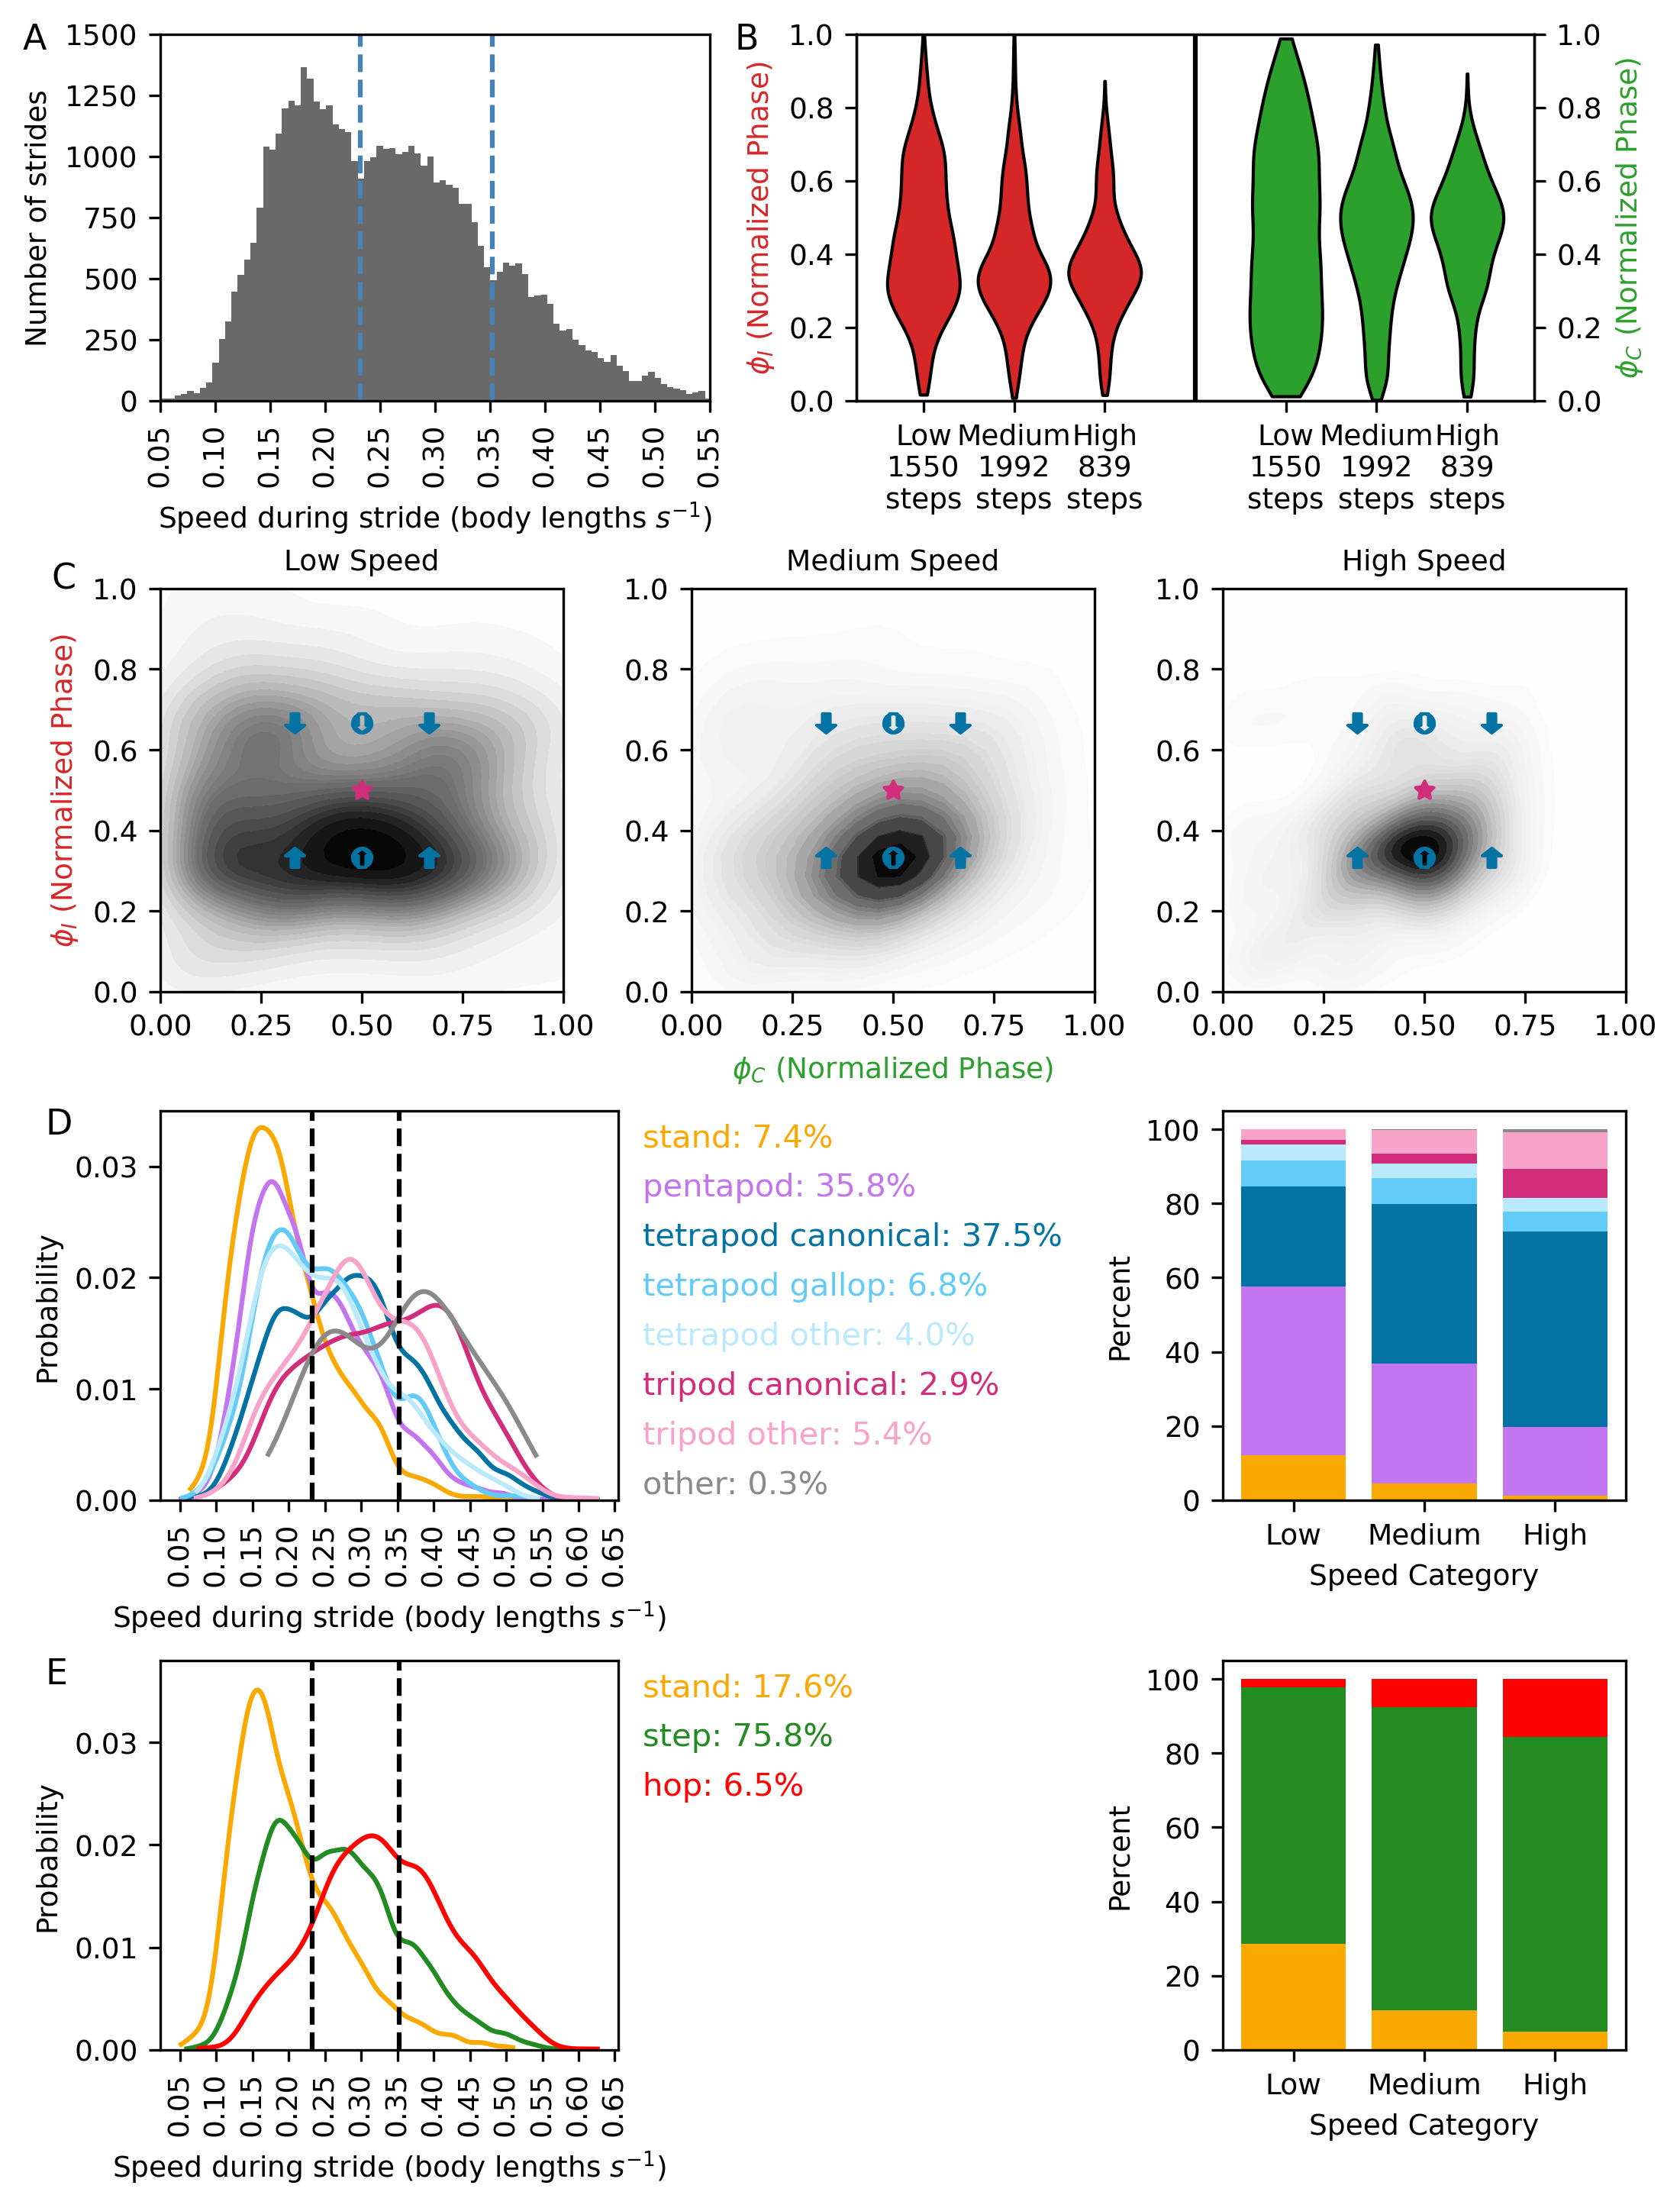

In [18]:
# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.232,0.352,1]

f = plt.figure(figsize=(8,10),dpi=300)
speed_ax = f.add_axes(  [0.1, 0.77, 0.3, 0.16]) # speed histogram
# sp_ipsi_ax = f.add_axes([0.6,0.78,0.3,0.17], sharex=speed_ax) # speed vs. ipsilateral offset greyscale heatmap
violin_ax = f.add_axes([0.48, 0.77, 0.37,0.16])
violin_ax2 = violin_ax.twinx()

low_ax = f.add_axes( [0.1, 0.5,0.22,0.2]) # low speed grayscale heat map
med_ax = f.add_axes( [0.39,0.5,0.22,0.2],sharex=low_ax, sharey=low_ax) # medium speed greyscale heat map
high_ax = f.add_axes([0.68,0.5,0.22,0.2],sharex=low_ax, sharey=low_ax) # high speed greyscale heat map

hex_part_ax = f.add_axes( [0.1, 0.29,0.25,0.17])
hex_leg_ax = f.add_axes(  [0.33,0.29,0.2,0.17])
hex_bar_ax = f.add_axes(  [0.68,0.29,0.22,0.17])

rear_part_ax = f.add_axes( [0.1, 0.05,0.25,0.17])
rear_leg_ax = f.add_axes(  [0.33,0.05,0.2,0.17])
rear_bar_ax = f.add_axes(  [0.68,0.05,0.22,0.17])

### speed histogram
import matplotlib.ticker as ticker
tick_spacing = 0.05

### SPEED HISTOGRAM
# load the gait_speeds data into a dataframe
# 'cruising' does not matter here because we only measure steps during cruising
gaitspeed_df = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
speed_col = 'speed (bodylength/s)' # 'speed (bodylength/s)' or 'speed (mm/s)' 

speed_ax.hist(gaitspeed_df[speed_col].values, bins=100, color='dimgrey')
speed_ax.set_ylabel('Number of strides')

### Partitioned speed violins for ipsilateral and contralateral offsets


### speed vs. ipsilateral offset greyscale heatmaps
# ipsi_proportions = []
# ipsi_speeds = []
# ipsi_offsets = []

# for leg in ipsi_offset_legs:
#     ipsi_offsets, ipsi_proportions, ipsi_speeds = swingTimingProportions(ipsi_offsets, ipsi_proportions, 
#                                                                          ipsi_speeds, step_df, leg, 
#                                                                          ipsi_legs[leg])

# print(len(ipsi_proportions), len(ipsi_speeds))

# sp_ipsi_ax = sns.kdeplot(ax=sp_ipsi_ax, x=ipsi_speeds, y=ipsi_proportions, fill=True, cmap='Greys', thresh=0, levels=50)
# sp_ipsi_ax.set_ylabel('Ipsilateral Offset', fontsize=axis_fontsize)
# sp_ipsi_ax.plot([0,1],[1/3,1/3],':',color=ipsi_color)
# sp_ipsi_ax.plot([0,1],[2/3,2/3],':',color=ipsi_color)
# sp_ipsi_ax.set_ylim([0,1])

for ax in [speed_ax]:#,sp_ipsi_ax]:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.tick_params(axis='x', rotation=90)
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.set_xlabel('Speed during stride (body lengths $s^{-1}$)', fontsize=axis_fontsize)
    # ax.xaxis.label.set_text('hihihihi') # cool

for i in [1,2]:
    speed_ax.plot([speed_boundaries[i],speed_boundaries[i]],[0,maxy],'--',color='steelblue')
#     sp_ipsi_ax.plot([speed_boundaries[i],speed_boundaries[i]],[0,1],'--',color='steelblue')

speed_ax.set_ylim([0,maxy])
speed_ax.set_xlim([0.05,0.55])

### violins
violins = violin_ax.violinplot(violin_data, positions=violin_positions, widths=0.8, 
                         showmeans=False, showextrema=False, showmedians=False)

for i, pc in enumerate(violins['bodies']):
    pc.set_facecolor(violin_colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1)

# violin_ax.plot([0,4],[1/3,1/3],':',c=tetra_color)
# violin_ax.plot([0,4],[1/2,1/2],':',c=tripod_color)
# violin_ax.plot([0,4],[2/3,2/3],':',c=tetra_color)
violin_ax.plot([4,4],[0,1],'-k')

violin_ax.set_ylabel('$ϕ_I$ (Normalized Phase)',color=ipsi_color,fontsize=axis_fontsize)
violin_ax2.set_ylabel('$ϕ_C$ (Normalized Phase)',color=contra_color,fontsize=axis_fontsize)
violin_ax.set_ylim([0,1])
violin_ax2.set_ylim([0,1])
violin_ax.set_xticks(violin_positions,violin_xlabs)
violin_ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

### three speeds in the middle   
cmap = 'Greys' # Greys or binary

low_ax = sns.kdeplot(ax=low_ax, x=slow_contra, y=slow_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
low_ax.set_title('Low Speed', fontsize=tick_fontsize)

med_ax = sns.kdeplot(ax=med_ax, x=medium_contra, y=medium_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
med_ax.set_title('Medium Speed', fontsize=tick_fontsize)

high_ax = sns.kdeplot(ax=high_ax, x=fast_contra, y=fast_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
high_ax.set_title('High Speed', fontsize=tick_fontsize)

for ax in [low_ax,med_ax,high_ax]:
    ax=offsetGaitstyleLabels(ax, with_text=False, markersize=6)
#     ax.set_xlim([0.05,0.95])
#     ax.set_ylim([0.05,0.95]) 
#     ax.set_xlabel('ϕc (Normalized Phase)', fontsize=tick_fontsize, color=contra_color)
    ax.xaxis.label.set_text('') # cool 
    ax.yaxis.label.set_text('') # cool 
    ax.set_aspect('equal')

low_ax.set_ylabel('$ϕ_I$ (Normalized Phase)', fontsize=tick_fontsize, color=ipsi_color)
med_ax.set_xlabel('$ϕ_C$ (Normalized Phase)', fontsize=tick_fontsize, color=contra_color)

### hexapod gait styles in speed partitions
hex_part_ax, hex_category_lists, hex_category_names, hex_color_dict = gaitDensityPlot(hex_part_ax, 
                                                                  hex_categories, 
                                                                  gaitspeed_df, 
                                                                  speed_col, 
                                                                  hex_include_unclassified)

# hex legend
legend_maxy = 5
legend_yincrement = 0.7
legend_x = 2
# how many are in each gait category
hex_percents_in_category = [np.round(len(x) * 100 / np.sum([len(x) for x in hex_category_lists]),1) for x in hex_category_lists]
for i, catname in enumerate(hex_category_names):
    hex_leg_ax.text(legend_x, legend_maxy-(i*legend_yincrement), 
            catname + ': ' + str(hex_percents_in_category[i]) + '%', 
            color=hex_color_dict[catname.replace(' ','_')])
hex_leg_ax.set_axis_off()
hex_leg_ax.set_xlim([1.5,4.5])
hex_leg_ax.set_ylim([0,5.5])

# hex proportions
hex_bar_ax = speedPartitionPlot(hex_bar_ax, speed_boundaries, hex_category_lists, 
                         hex_category_names, hex_color_dict)


### rear gait styles in speed partitions
rear_part_ax, rear_category_lists, rear_category_names, rear_color_dict = gaitDensityPlot(rear_part_ax, 
                                                                  rear_categories, 
                                                                  gaitspeed_df, 
                                                                  speed_col, 
                                                                  rear_include_unclassified)

# rear legend
legend_maxy = 5
legend_yincrement = 0.7
legend_x = 2
# how many are in each gait category
rear_percents_in_category = [np.round(len(x) * 100 / np.sum([len(x) for x in rear_category_lists]),1) for x in rear_category_lists]
for i, catname in enumerate(rear_category_names):
    rear_leg_ax.text(legend_x, legend_maxy-(i*legend_yincrement), 
            catname + ': ' + str(rear_percents_in_category[i]) + '%', 
            color=rear_color_dict[catname.replace(' ','_')])
rear_leg_ax.set_axis_off()
rear_leg_ax.set_xlim([1.5,4.5])
rear_leg_ax.set_ylim([0,5.5])

# rear proportions
rear_bar_ax = speedPartitionPlot(rear_bar_ax, speed_boundaries, rear_category_lists, 
                         rear_category_names, rear_color_dict)

max_lines = [0.035, 0.038]
for i, ax in enumerate([hex_part_ax, rear_part_ax]):
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.tick_params(axis='x', rotation=90)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.set_xlabel('Speed during stride (body lengths $s^{-1}$)', fontsize=axis_fontsize)
    max_line = max_lines[i]
    ax.plot([speed_boundaries[1],speed_boundaries[1]],[0,max_line],'--k')
    ax.plot([speed_boundaries[2],speed_boundaries[2]],[0,max_line],'--k')
    ax.set_ylim([0,max_line]) 

for ax in [hex_bar_ax, rear_bar_ax]:
    ax.xaxis.label.set_text('Speed Category')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    
###
for ax in [speed_ax, low_ax, med_ax, high_ax, hex_part_ax, rear_part_ax, violin_ax, violin_ax2]:
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.yaxis.label.set_size(tick_fontsize)
    
# add figure letter labels
speed_ax.annotate('A', xy=(-0.25, 0.96), xycoords='axes fraction', fontsize=axis_fontsize)
violin_ax.annotate('B', xy=(-0.18, 0.96), xycoords='axes fraction', fontsize=axis_fontsize)
low_ax.annotate('C', xy=(-0.27, 1), xycoords='axes fraction', fontsize=axis_fontsize)
hex_part_ax.annotate('D', xy=(-0.25, 0.94), xycoords='axes fraction', fontsize=axis_fontsize)
rear_part_ax.annotate('E', xy=(-0.25, 0.94), xycoords='axes fraction', fontsize=axis_fontsize)


plt.show()